# Analysis of data
In this notebook we'll look at the downloaded data and explore what it tells us

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas
from shapely.geometry import Point, LineString
from datetime import datetime

In [2]:
geo_data_dir = '../data/geo_data'
weather_data_dir = '../data/weather_data'
taxi_zones_file = '../data/taxi_zones'
green_tripdata_file = '../data/taxi_data/consolidated_green_tripdata.csv'
green_cleansed_tripdata_file = '../data/taxi_data/cleansed_consolidated_green_tripdata.csv'
yellow_tripdata_file = '../data/taxi_data/consolidated_yellow_tripdata.csv'

* Load the shape file of NYC (this contains the shape files for each location below) and display it

In [3]:
def get_taxi_zones(taxi_zones_file):
    taxi_zones = geopandas.read_file(taxi_zones_file).set_index('OBJECTID')
    zone_ids = taxi_zones.index.tolist()
    taxi_zones['centroids'] = taxi_zones.geometry.centroid
    return taxi_zones, zone_ids

,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroids
OBJECTID,,,,,,,
1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",POINT (935996.8210162065 191376.749530832)
2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",POINT (1031085.718603285 164018.7544032017)
3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",POINT (1026452.616873473 254265.4786585689)
4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",POINT (990633.9806410479 202959.7823911368)
5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",POINT (931871.3700680139 140681.3513759734)
6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,"POLYGON ((966568.7466657609 158679.854687795, ...",POINT (964319.735448061 157998.9356119239)
7,0.107417,0.000390,Astoria,7,Queens,"POLYGON ((1010804.217962816 218919.6406951398,...",POINT (1006496.679158681 216719.2181686789)
8,0.027591,0.000027,Astoria Park,8,Queens,"POLYGON ((1005482.276373357 221686.4661663175,...",POINT (1005551.57117787 222936.0875515854)
9,0.099784,0.000338,Auburndale,9,Queens,"POLYGON ((1043803.993348822 216615.9250395149,...",POINT (1043002.677424325 212969.8490136597)


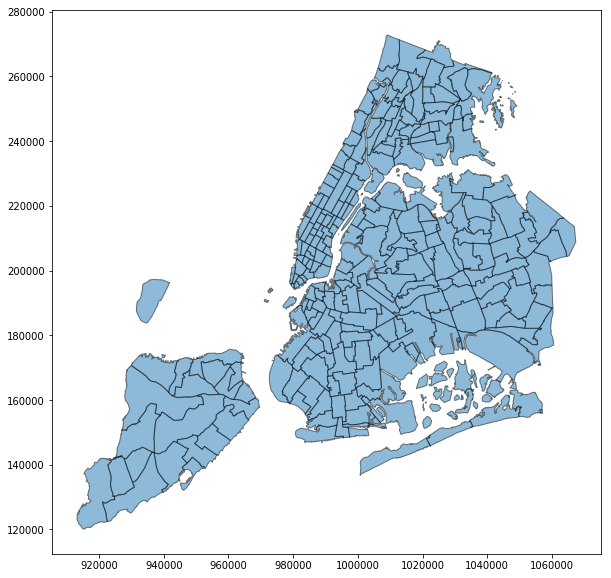

In [4]:
taxi_zones, zone_ids = get_taxi_zones(taxi_zones_file)
taxi_zones.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
taxi_zones.head(10)

### Load the taxi data

Load and cleanse the trip data

In [11]:
def load_tripdata(tripdata_file, zone_ids, min_trip_duration=1, max_trip_duration=60, delimiter=',', save=True): 
    def get_trip_durations(tripdata_file):
        durations = []
        for i, trip in tripdata.iterrows():
            pickup_time = trip['tpep_pickup_datetime']  #"2017-07-01 00:56:23"
            dropoff_time = trip['tpep_dropoff_datetime']  #"2017-07-01 00:59:30"
            duration = datetime.strptime(dropoff_time, '%Y-%m-%d %H:%M:%S') - datetime.strptime(pickup_time, '%Y-%m-%d %H:%M:%S')
            durations.append(duration.seconds / 60)    # Convert to minutes
        return durations
    
    tripdata = pd.read_csv(tripdata_file, delimiter=delimiter)
    print('Loaded trip data from {}'.format(tripdata_file))
    print('Trip data contains {} rows'.format(len(tripdata)))
    # Drop rows with zero and NaN values
    tripdata = tripdata[(tripdata != 0).all(1)].dropna()
    tripdata = tripdata[(tripdata['PULocationID'].isin(zone_ids)) & 
                                (tripdata['DOLocationID'].isin(zone_ids))]
    # Get trip durations and remove outliers
    print('Calculating trip durations for {} rows'.format(len(tripdata)))
    tripdata['duration'] = get_trip_durations(tripdata)
    print('Removing rows with {} < duration < {}'.format(min_trip_duration, max_trip_duration))
    tripdata = tripdata[(tripdata['duration'] >= min_trip_duration ) & ( tripdata['duration'] <= max_trip_duration)]
    # Save and return cleansed data
    print('Cleansed trip data contains {} rows'.format(len(tripdata)))
    if save:
        directory = os.path.dirname(tripdata_file)
        file = os.path.basename(tripdata_file)
        cleansed_file = os.path.join(directory, 'cleansed_{}'.format(file))
        print('Saving cleansed data to {}'.format(cleansed_file))
        tripdata.to_csv(cleansed_file, sep=delimiter)
        print('Done')
    return tripdata       

* Load trip data

In [12]:
tripdata = load_tripdata(green_tripdata_file, zone_ids)
tripdata.head(10)

Loaded trip data from ../data/taxi_data/consolidated_green_tripdata.csv
Trip data contains 10108112 rows
Calculating trip durations for 9946538 rows
Removing rows with 1 < duration < 60
Cleansed trip data contains 9739804 rows
Saving cleansed data to ../data/taxi_data/cleansed_consolidated_green_tripdata.csv
Done


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,total_amount,duration
1,2,2017-07-01 00:56:23,2017-07-01 00:59:30,14,14,1,0.81,5.80,3.116667
2,2,2017-07-01 00:15:25,2017-07-01 00:34:24,112,61,1,4.97,23.16,18.983333
3,2,2017-07-01 00:55:06,2017-07-01 00:59:08,92,92,1,0.83,6.80,4.033333
4,2,2017-07-01 00:34:05,2017-07-01 00:50:44,75,79,1,4.99,19.30,16.650000
5,2,2017-07-01 00:09:19,2017-07-01 00:16:58,61,188,1,1.72,9.30,7.650000
6,2,2017-07-01 00:24:20,2017-07-01 00:30:54,188,89,1,1.88,8.80,6.566667
7,2,2017-07-01 00:41:22,2017-07-01 01:13:02,89,71,1,1.74,21.30,31.666667
8,2,2017-07-01 00:20:02,2017-07-01 00:39:31,255,129,1,5.85,26.16,19.483333
9,2,2017-07-01 00:46:38,2017-07-01 01:12:26,255,181,2,6.38,29.75,25.800000
10,2,2017-07-01 00:07:32,2017-07-01 00:10:34,49,49,1,0.84,6.96,3.033333


* Graph trip times

Text(0,0.5,'Number of samples')

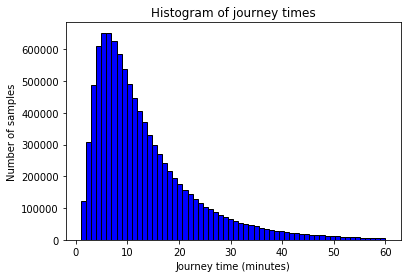

In [15]:
max_dur_to_plot = 60    # Minutes
plt.hist(tripdata[tripdata['duration'] < max_dur_to_plot]['duration'], color = 'blue', edgecolor = 'black',
         bins = int((max_dur_to_plot)))
plt.title('Histogram of journey times')
plt.xlabel('Journey time (minutes)')
plt.ylabel('Number of samples')

### Restart here

TODO - Start by loading the CSV

In [33]:
green_tripdata = pd.read_csv(green_cleansed_tripdata_file, delimiter=',')

* Count of each pickup (PU) and drop-off (DO) location ID

In [34]:
def count_by_location_ids(tripdata):
    count_by_PU = tripdata.groupby('PULocationID')['PULocationID'].count()
    count_by_DO = tripdata.groupby('DOLocationID')['DOLocationID'].count()
    return count_by_PU, count_by_DO

In [35]:
taxi_zones['Count_by_PULocationID'], taxi_zones['Count_by_DOLocationID'] = count_by_location_ids(tripdata)
taxi_zones.head(10)

,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,centroids,Count_by_PULocationID,Count_by_DOLocationID
OBJECTID,,,,,,,,,
1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",POINT (935996.8210162065 191376.749530832),11.0,2549.0
2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",POINT (1031085.718603285 164018.7544032017),3.0,24.0
3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",POINT (1026452.616873473 254265.4786585689),4266.0,5875.0
4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",POINT (990633.9806410479 202959.7823911368),9.0,11980.0
5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",POINT (931871.3700680139 140681.3513759734),4.0,46.0
6,0.150491,0.000606,Arrochar/Fort Wadsworth,6,Staten Island,"POLYGON ((966568.7466657609 158679.854687795, ...",POINT (964319.735448061 157998.9356119239),44.0,123.0
7,0.107417,0.000390,Astoria,7,Queens,"POLYGON ((1010804.217962816 218919.6406951398,...",POINT (1006496.679158681 216719.2181686789),489716.0,307970.0
8,0.027591,0.000027,Astoria Park,8,Queens,"POLYGON ((1005482.276373357 221686.4661663175,...",POINT (1005551.57117787 222936.0875515854),247.0,1644.0
9,0.099784,0.000338,Auburndale,9,Queens,"POLYGON ((1043803.993348822 216615.9250395149,...",POINT (1043002.677424325 212969.8490136597),1713.0,4434.0


* This CRS will transform the map into lat/long coordinates

In [36]:
#taxi_zones_crs = taxi_zones.crs
#print(taxi_zones_crs)
# taxi_zones = taxi_zones.to_crs({'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True})

### Plot volumes of pickups by zone on the map

In [37]:
def plot_volumes_by_location(taxi_zones, column, title, figsize=(10,10), cmap='Blues', scheme='quantiles'):
    fig, ax = plt.subplots(1, figsize=figsize)
    taxi_zones.plot(column=column, cmap=cmap, scheme=scheme, linewidth=0.8, ax=ax, edgecolor='0.8')
    ax.set_title(title, fontdict={'fontsize': 25, 'fontweight' : 3})

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/anaconda3/lib/python3.7/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


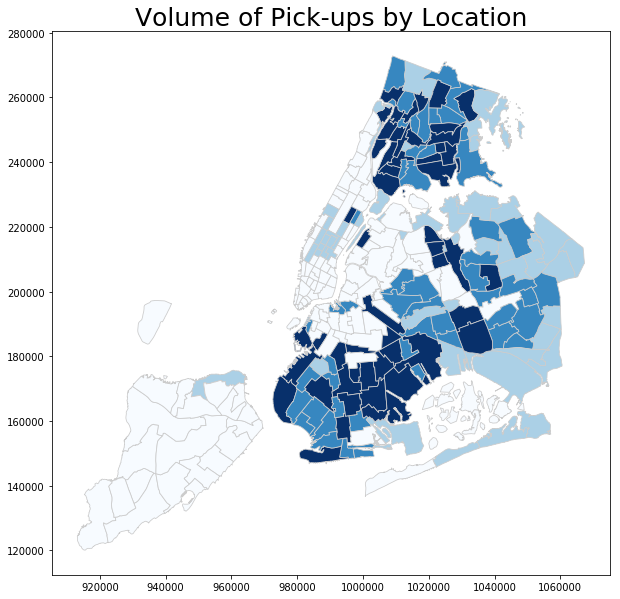

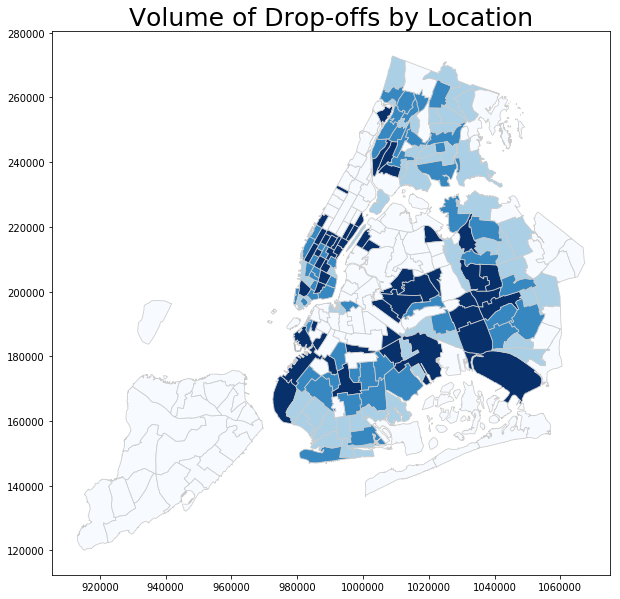

In [38]:
plot_volumes_by_location(taxi_zones, 'Count_by_PULocationID', 'Volume of Pick-ups by Location')
plot_volumes_by_location(taxi_zones, 'Count_by_DOLocationID', 'Volume of Drop-offs by Location')

* Now calculate the number of trips by unique pickup/drop-off combination

In [39]:
def calc_unique_trips_by_locations(tripdata):
    counts_by_trip = tripdata.groupby(['PULocationID', 'DOLocationID'])[['PULocationID', 'DOLocationID']].size().reset_index()
    counts_by_trip.rename(columns={0: 'count'}, inplace=True)
    return counts_by_trip

In [40]:
counts_by_trip = calc_unique_trips_by_locations(tripdata)
counts_by_trip.head(10)

,PULocationID,DOLocationID,count
0,1,1,6
1,1,23,1
2,1,66,2
3,1,166,1
4,1,243,1
5,2,196,1
6,2,197,1
7,2,216,1
8,3,3,167
9,3,4,2


* Determine linestrings for each unique trip

In [41]:
def get_trip_linestrings(taxi_zones, counts_by_trip):
    journeys = []
    for i, journey in counts_by_trip.iterrows():
        #print(journey[['PULocationID', 'DOLocationID']].values)
        start_centroid = taxi_zones.loc[journey['PULocationID'], 'centroids']
        end_centroid = taxi_zones.loc[journey['DOLocationID'], 'centroids']
        journeys.append(LineString([start_centroid, end_centroid]))
    return journeys

In [42]:
counts_by_trip['journey'] = get_trip_linestrings(taxi_zones, counts_by_trip)
counts_by_trip.head(10)

,PULocationID,DOLocationID,count,journey
0,1,1,6,LINESTRING (935996.8210162065 191376.749530832...
1,1,23,1,LINESTRING (935996.8210162065 191376.749530832...
2,1,66,2,LINESTRING (935996.8210162065 191376.749530832...
3,1,166,1,LINESTRING (935996.8210162065 191376.749530832...
4,1,243,1,LINESTRING (935996.8210162065 191376.749530832...
5,2,196,1,LINESTRING (1031085.718603285 164018.754403201...
6,2,197,1,LINESTRING (1031085.718603285 164018.754403201...
7,2,216,1,LINESTRING (1031085.718603285 164018.754403201...
8,3,3,167,LINESTRING (1026452.616873473 254265.478658568...
9,3,4,2,LINESTRING (1026452.616873473 254265.478658568...


In [43]:
# journeys = geopandas.GeoDataFrame(counts_by_trip, geometry='journey')
# journeys.plot(figsize=(15, 15), color='red')

* Now plot on the map of NYC

In [44]:
def plot_trips(taxi_zones, counts_by_trip, column, title, figsize=(10,10), cmap='Blues', scheme='quantiles'):
    ax = taxi_zones.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
    journeys = geopandas.GeoDataFrame(counts_by_trip, geometry='journey')
    # journeys.crs = taxi_zones.crs  #{'init': 'epsg:4326'}
    # journeys.to_crs(taxi_zones.crs)
    journeys.plot(ax=ax, color='red')
    ax.set_title(title, fontdict={'fontsize': 25, 'fontweight' : 3})

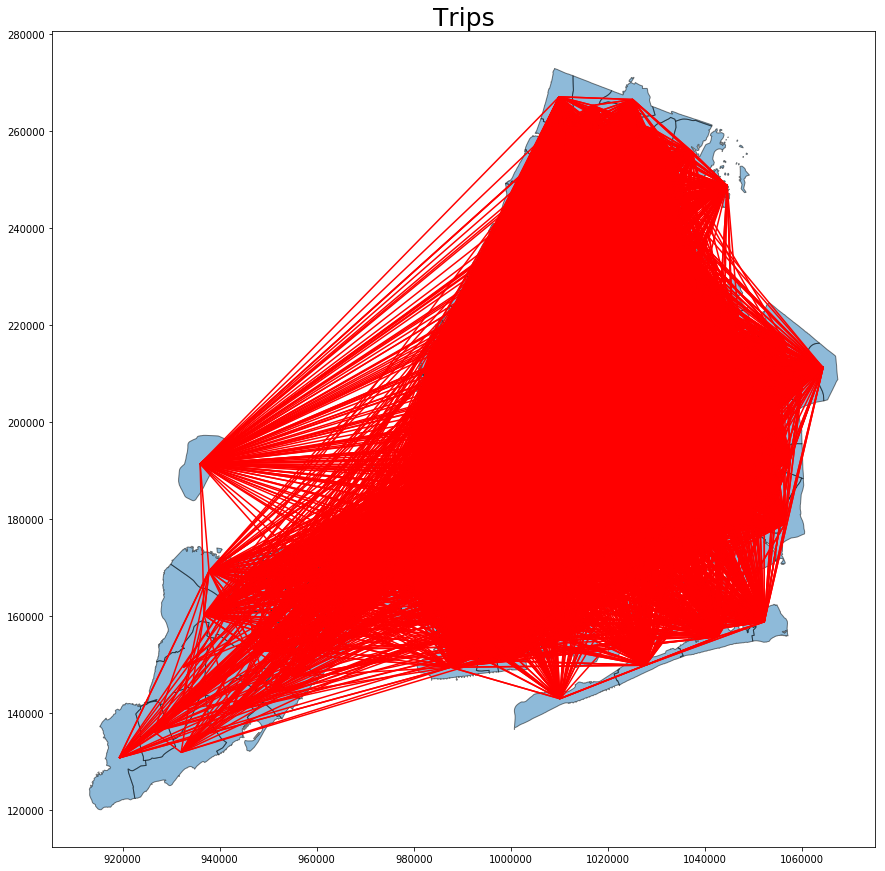

In [45]:
plot_trips(taxi_zones, counts_by_trip, 'journey', 'Trips')

### Trip meta-data

In [64]:
trip_meta = pd.DataFrame()
for i, unique_trip in counts_by_trip.iterrows():
    PULocationID = unique_trip['PULocationID']
    DOLocationID = unique_trip['DOLocationID']
    unique_trip_samples = tripdata[(tripdata['PULocationID'] == PULocationID) & (tripdata['DOLocationID'] == DOLocationID)]
    min_trip_time = unique_trip_samples['duration'].min()
    max_trip_time = unique_trip_samples['duration'].max()
    mean_trip_time = unique_trip_samples['duration'].mean()
    min_trip_dist = unique_trip_samples['trip_distance'].min()
    max_trip_dist = unique_trip_samples['trip_distance'].max()
    mean_trip_dist = unique_trip_samples['trip_distance'].mean()
    min_trip_amnt = unique_trip_samples['total_amount'].min()
    max_trip_amnt = unique_trip_samples['total_amount'].max()
    mean_trip_amnt = unique_trip_samples['total_amount'].mean()
    key = '{:03d}-{:03d}'.format(PULocationID, DOLocationID)
    trip_meta = trip_meta.append({
        'key': key, 
        'min_trip_time': min_trip_time,
        'max_trip_time': max_trip_time,
        'mean_trip_time': mean_trip_time,
        'min_trip_dist': min_trip_dist, 
        'max_trip_dist': max_trip_dist,
        'mean_trip_dist': max_trip_dist,
        'min_trip_amnt': min_trip_amnt,
        'max_trip_amnt': max_trip_amnt,
        'mean_trip_amnt': mean_trip_amnt
    }, ignore_index=True)                                    

In [65]:
trip_meta.set_index('key')

,max_trip_amnt,max_trip_dist,max_trip_time,mean_trip_amnt,mean_trip_dist,mean_trip_time,min_trip_amnt,min_trip_dist,min_trip_time
key,,,,,,,,,
001-001,120.00,23.40,16.466667,60.620000,23.40,6.447222,4.30,0.01,1.016667
001-023,36.80,13.50,48.316667,36.800000,13.50,48.316667,36.80,13.50,48.316667
001-066,102.30,16.20,39.183333,98.210000,16.20,35.816667,94.12,15.70,32.450000
001-166,103.80,26.64,53.266667,103.800000,26.64,53.266667,103.80,26.64,53.266667
001-243,104.80,23.90,37.833333,104.800000,23.90,37.833333,104.80,23.90,37.833333
002-196,27.30,8.70,23.700000,27.300000,8.70,23.700000,27.30,8.70,23.700000
002-197,30.59,6.37,21.033333,30.590000,6.37,21.033333,30.59,6.37,21.033333
002-216,62.80,12.99,45.000000,62.800000,12.99,45.000000,62.80,12.99,45.000000
003-003,75.00,14.75,57.266667,9.850898,14.75,8.922156,-75.00,0.01,1.133333


In [67]:
import pickle
pickle.dump(trip_meta, open('../data/taxi_data/taxi_meta.p', "wb"))